In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

## Dataset

Let us begin with reading the dataset.

In [4]:
df = pd.read_csv("./train_ship_segmentations_v2.csv")
df['EncodedPixels'] = df['EncodedPixels'].astype('string')

In [9]:
df.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                               <NA>
1  0001124c7.jpg                                               <NA>
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

Evidently, we have two columns: 'ImageId', which is simply the id of the image, and 'EncodedPixels', which is the label of the image.

'EncodedPixels' consists of pairs of numbers (x, y), where x is the position of a pixel in the image, and y is the number of pixels starting from x which denote ships. The numeration goes over columns of the image (the next pixel is the one immediately below, or the starting one in the next column for a bottom-most pixel).

NaN value means that image has no ships.

## Feature Extraction

Let's add new features:
* **ImageHeight** - image height
* **ImageWidth** - image width
* **ShipAreaPercentage** - fraction of the ship segmentation area in the image. Measured as a percentage, from 0 to 100%

A helper function to read an image from the training directory.

In [10]:
def get_train_image(name: str):
    path = f'./training_images/{name}'
    return cv2.imread(path)

A helper function which assign respective values to 'ImageWidth' and 'ImageHeight' columns.

In [14]:
def extract_features_from_image(row: pd.Series) -> pd.Series:
    image = get_train_image(row['ImageId'])
    row['ImageHeight'], row['ImageWidth'], _ = image.shape
    return row

df = df.apply(lambda x: extract_features_from_image(x), axis=1)

Finally, let us create the 'ShipAreaPercentage' column.

In [15]:
def n_pixels(encoded_pixels: str) -> int:
    if pd.isna(encoded_pixels):
        return 0
    return np.array(encoded_pixels.split()[1::2], dtype=int).sum()

df['ShipAreaPercentage'] = df.apply(lambda x: n_pixels(x['EncodedPixels']) / (x['ImageHeight'] * x['ImageWidth']) * 100, axis=1)

## Corrupted images

Our dataset contains a corrupted image.

In [16]:
get_train_image('6384c3e78.jpg')

6384c3e78.jpg - corrupted image, a `Premature end of JPEG file` error occurs when reading the file.

In [19]:
corrupted_images = ['6384c3e78.jpg']
df[df['ImageId'].isin(corrupted_images)]

ImageId EncodedPixels  ImageHeight  ImageWidth  \
90158  6384c3e78.jpg          <NA>          768         768   

       ShipAreaPercentage  
90158                 0.0

So let's delete this image.

In [21]:
df = df.drop(df[df['ImageId'].isin(corrupted_images)].index)
df[df['ImageId'].isin(corrupted_images)]

Empty DataFrame
Columns: [ImageId, EncodedPixels, ImageHeight, ImageWidth, ShipAreaPercentage]
Index: []

## Data Exploration

In [22]:
print(f'The table contains {df.shape[0]} rows.')
df.head()

The table contains 231722 rows.


ImageId                                      EncodedPixels  \
0  00003e153.jpg                                               <NA>   
1  0001124c7.jpg                                               <NA>   
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...   
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...   
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...   

   ImageHeight  ImageWidth  ShipAreaPercentage  
0          768         768            0.000000  
1          768         768            0.000000  
2          768         768            0.574409  
3          768         768            0.030009  
4          768         768            0.025092

We see that the training dataframe includes 231722 rows. On the other hand, we see that rows 3 and 4 have the dame image id. Let's see how many images are there.

In [23]:
n_train_images = df['ImageId'].nunique()
print(f'There are {n_train_images} train images.')

There are 192555 train images.


## Image resolution

What sizes are there in our dataset?

In [25]:
print(df['ImageHeight'].value_counts())
print(df['ImageWidth'].value_counts())

ImageHeight
768    231722
Name: count, dtype: int64
ImageWidth
768    231722
Name: count, dtype: int64


All images have the same resolution 768 * 768 * 3.

## Ship segmentation area distribution

Let's see what fraction of total area do ships take.

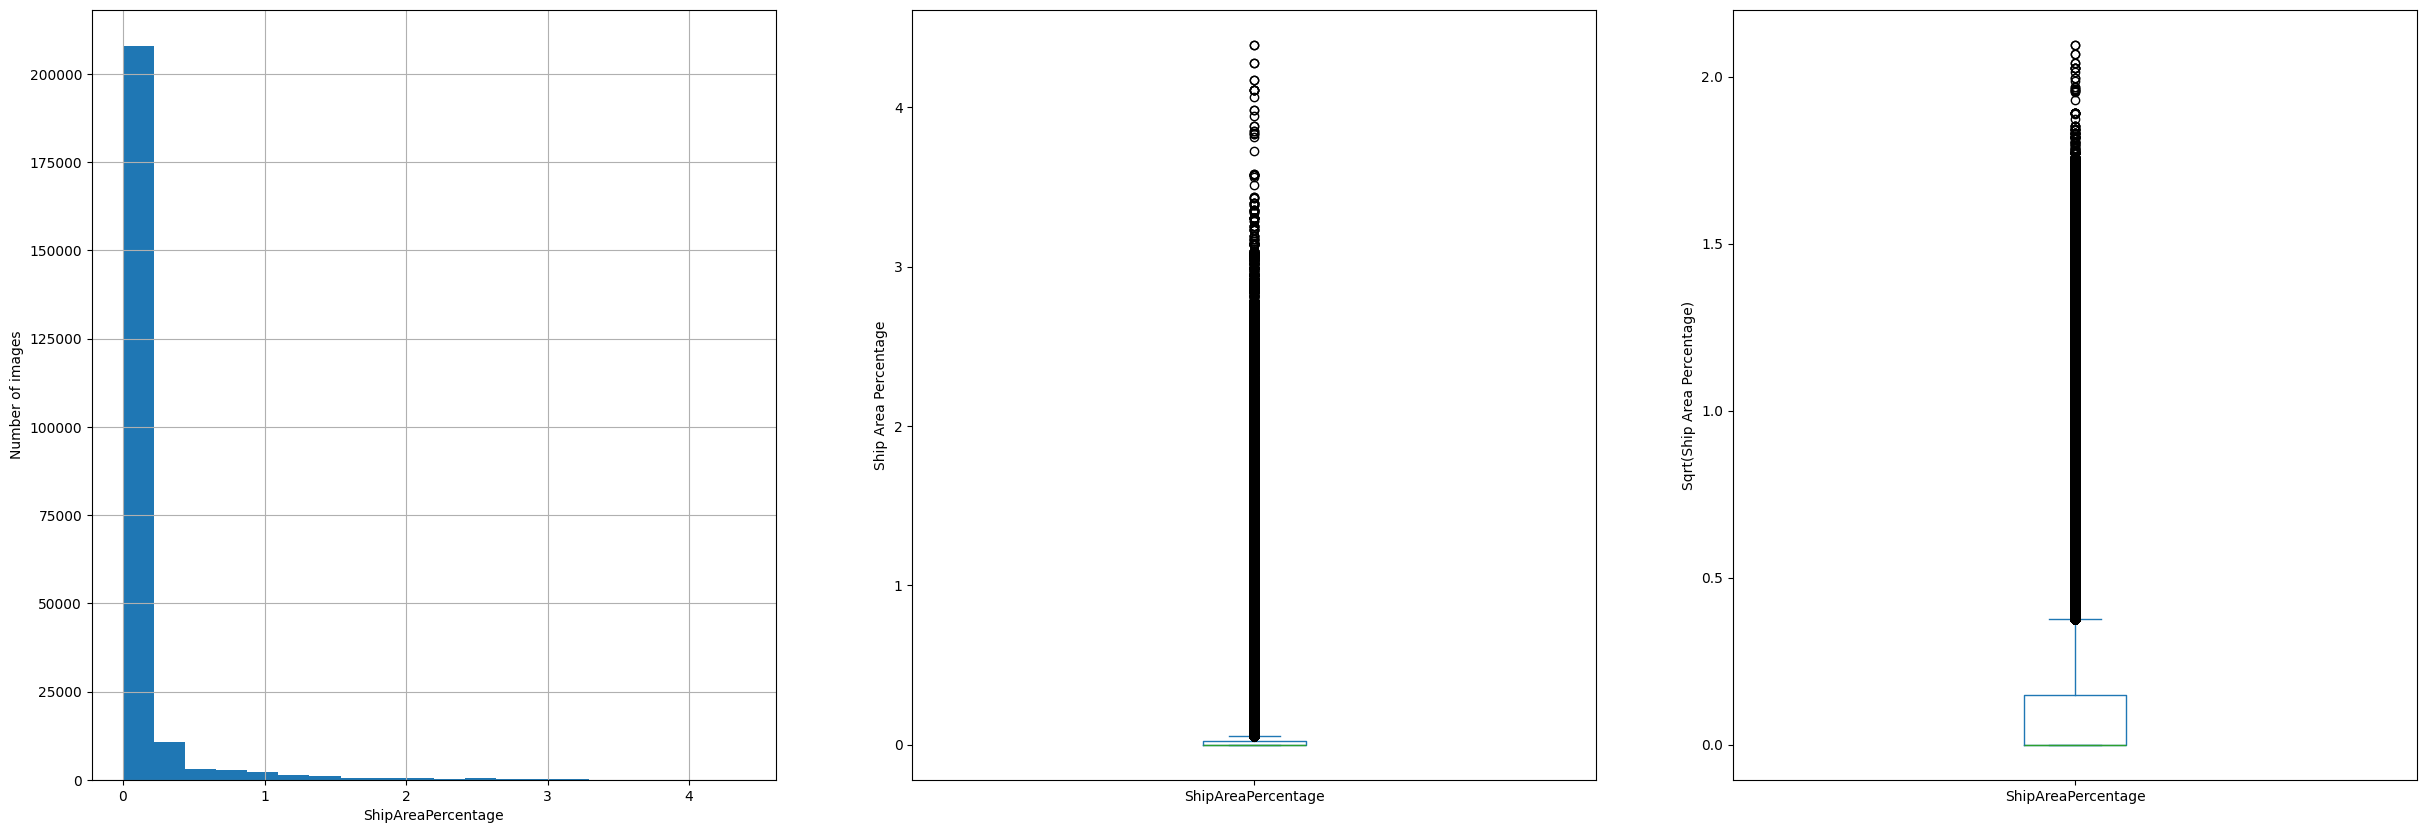

In [32]:
f,ax=plt.subplots(1, 3, figsize=(30, 10))

df['ShipAreaPercentage'].hist(bins=20, ax=ax[0])
ax[0].set_ylabel('Number of images')
ax[0].set_xlabel('ShipAreaPercentage')
df['ShipAreaPercentage'].plot.box(ax=ax[1])
ax[1].set_ylabel('Ship Area Percentage')
ax[1].set_xlabel('')
df['ShipAreaPercentage'].apply(lambda x: x ** 0.5).plot.box(ax=ax[2])
ax[2].set_ylabel('Sqrt(Ship Area Percentage)')
ax[2].set_xlabel('');

All ships are very small in the images. In fact, they occupy no more than 4% of the image. Most of the ships take up less than 0.1% of the image.

## Display ship segmentation pixels

A helper function to show the images with pixels encoded, so that the ships are seen very clearly.

In [33]:
def show_image_with_encoded_pixels(image_id: str):
    rows = df[df['ImageId'] == image_id]
    if len(rows) == 0:
        return
    
    image = get_train_image(image_id)
    image_size, _, _ = image.shape
    ship_count = len(rows)
    all_ships = np.zeros_like(image)

    ax_rows_number = ship_count + 1
    f,ax = plt.subplots(ax_rows_number, 3, figsize=(15, 5 * ax_rows_number))

    for i in range(ship_count):
        image_info = rows.iloc[i]

        encoded_pixels = np.array(image_info['EncodedPixels'].split(), dtype=int)
        pixels, shift = encoded_pixels[::2], encoded_pixels[1::2]
        ship = np.zeros_like(image)

        for pixel, shift in zip(pixels, shift):
            for j in range(shift):
                cur_pixel = pixel + j - 1
                ship[cur_pixel % image_size, cur_pixel // image_size] = [255, 255, 255]
        all_ships += ship
        
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(ship)
        ax[i, 2].imshow(image * (ship // 255))
        
    ax[ship_count, 0].imshow(image)
    ax[ship_count, 1].imshow(all_ships)
    ax[ship_count, 2].imshow(image * (all_ships // 255))
    plt.show()

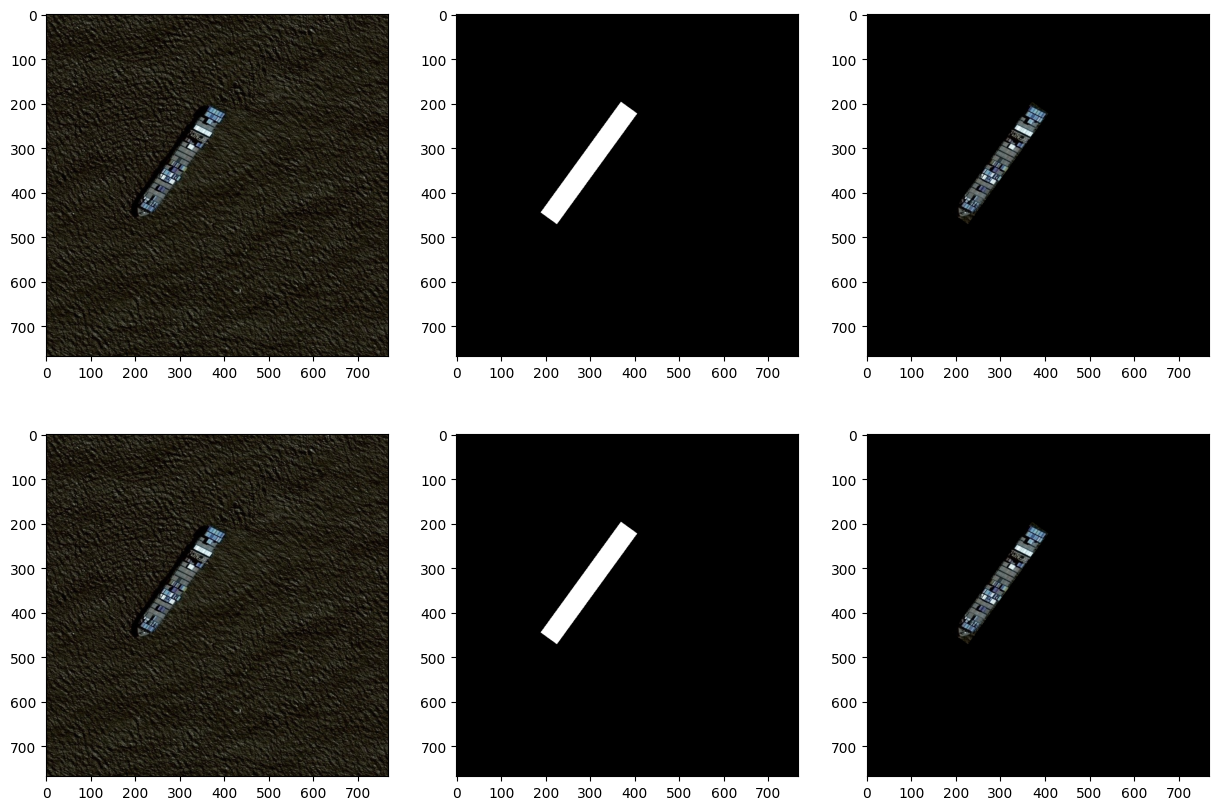

ImageId                                      EncodedPixels  \
32  0006c52e8.jpg  146366 1 147132 4 147899 5 148666 7 149432 10 ...   

    ImageHeight  ImageWidth  ShipAreaPercentage  
32          768         768            2.355448

In [35]:
image_id = '0006c52e8.jpg'
show_image_with_encoded_pixels(image_id)
df[df['ImageId'] == image_id]

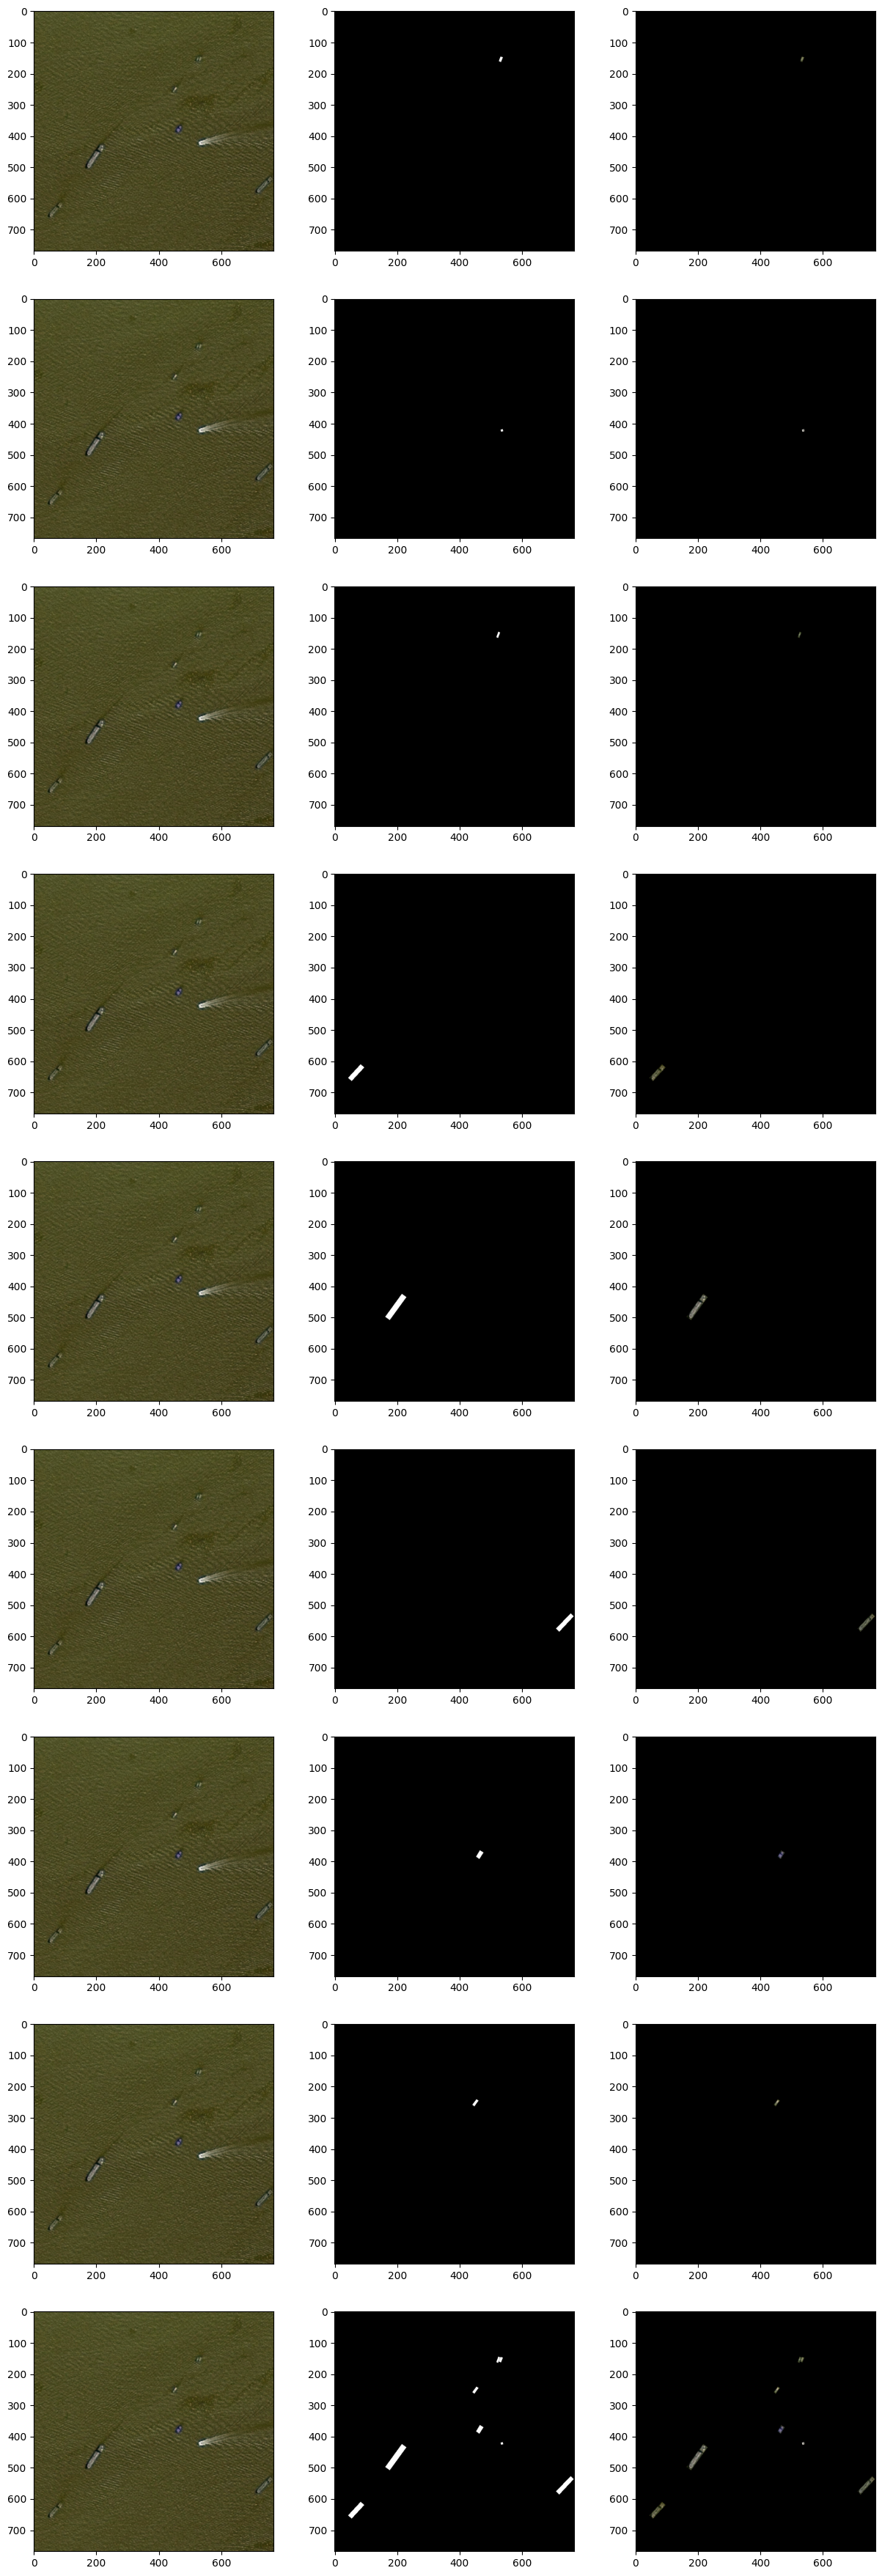

ImageId                                      EncodedPixels  \
30823  225134675.jpg  404896 2 405661 5 406426 9 407192 11 407957 15...   
30824  225134675.jpg  409765 4 410533 7 411301 7 412069 7 412836 8 4...   
30825  225134675.jpg  398754 2 399519 5 400284 9 401050 11 401815 15...   
30826  225134675.jpg  34446 1 35213 3 35980 5 36747 7 37514 9 38281 ...   
30827  225134675.jpg  125683 1 126449 4 127216 5 127983 7 128749 10 ...   
30828  225134675.jpg  545857 1 546624 3 547391 5 548158 7 548925 9 5...   
30829  225134675.jpg  349057 1 349823 4 350589 6 351356 8 352122 11 ...   
30830  225134675.jpg  339715 1 340482 3 341248 6 342015 7 342782 9 3...   

       ImageHeight  ImageWidth  ShipAreaPercentage  
30823          768         768            0.021871  
30824          768         768            0.008477  
30825          768         768            0.020345  
30826          768         768            0.157335  
30827          768         768            0.278049  
30828          768         768            0.163100  
30829          768         768            0.055610  
30830          768         768            0.031704

In [37]:
image_id = '225134675.jpg'
show_image_with_encoded_pixels(image_id)
df[df['ImageId'] == image_id]

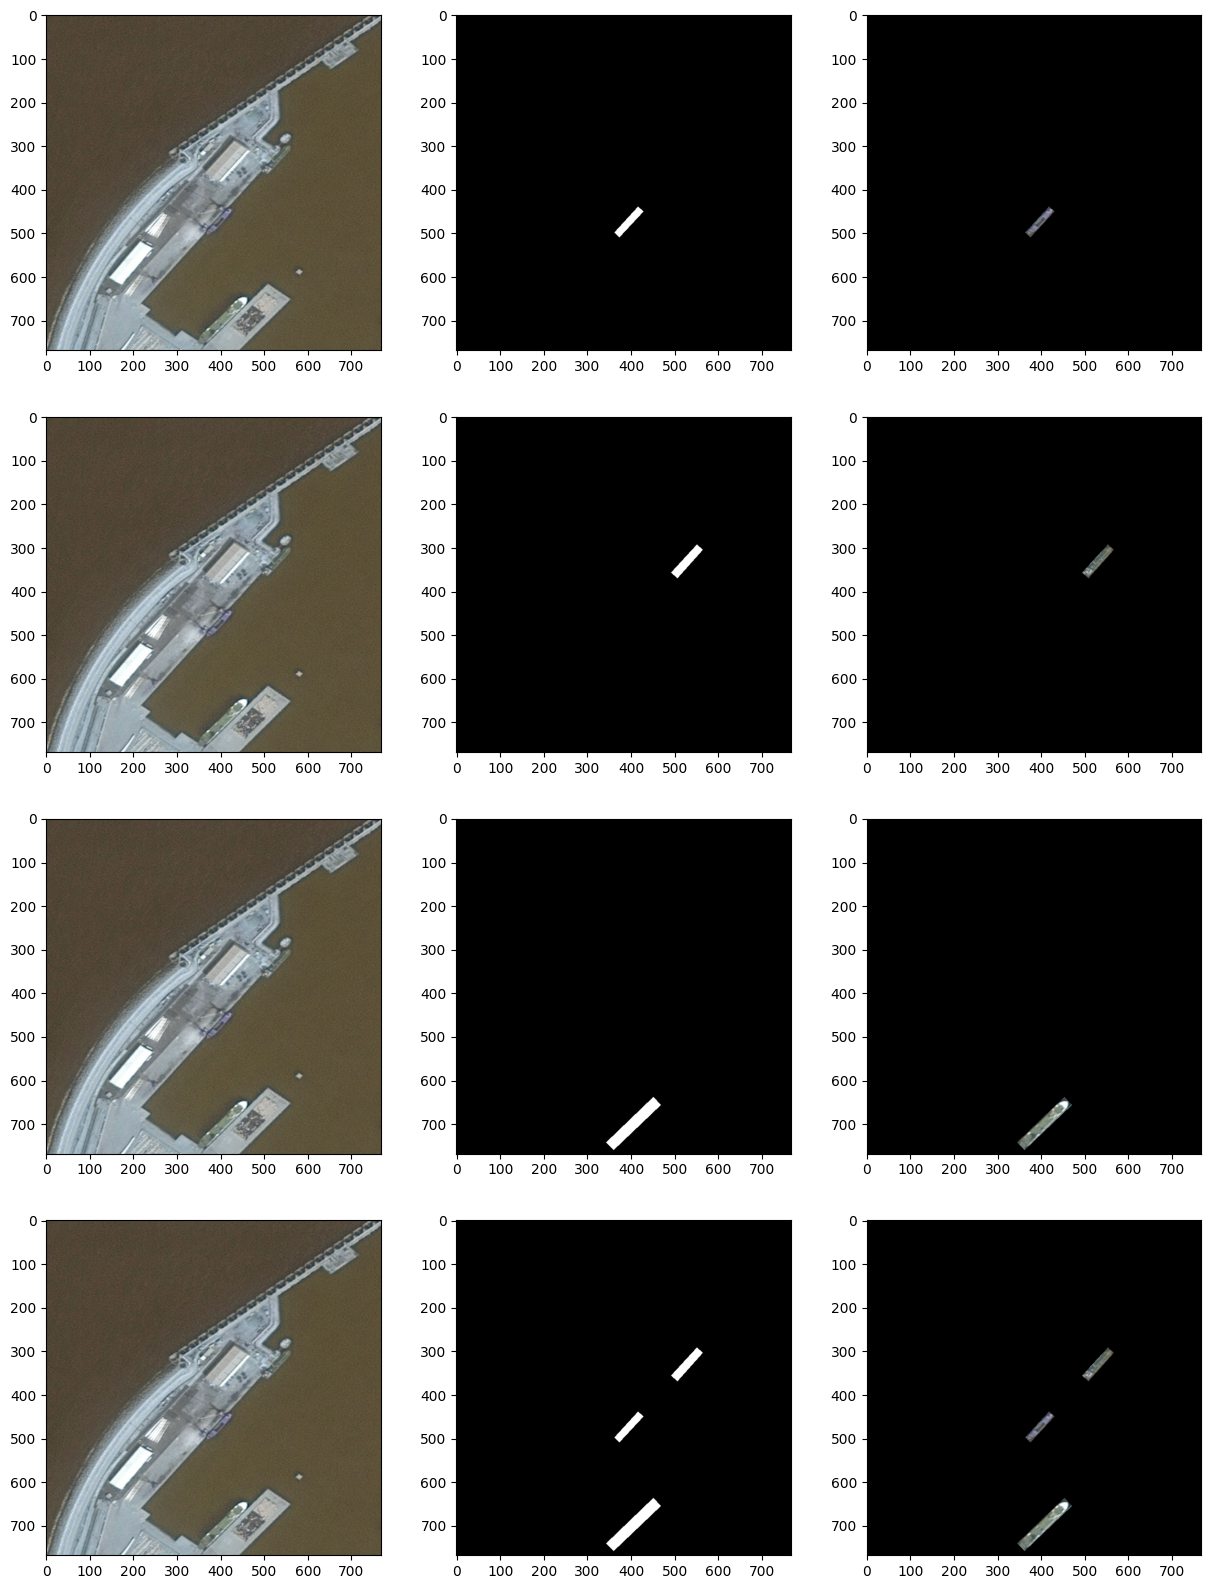

ImageId                                      EncodedPixels  \
3762  04163641b.jpg  279283 1 280050 3 280817 5 281584 7 282351 9 2...   
3763  04163641b.jpg  378981 1 379748 3 380515 5 381282 7 382049 9 3...   
3764  04163641b.jpg  264934 1 265701 3 266468 5 267235 7 268002 9 2...   

      ImageHeight  ImageWidth  ShipAreaPercentage  
3762          768         768            0.228882  
3763          768         768            0.285000  
3764          768         768            0.640191

In [44]:
image_id = '04163641b.jpg'
show_image_with_encoded_pixels(image_id)
df[df['ImageId'] == image_id]

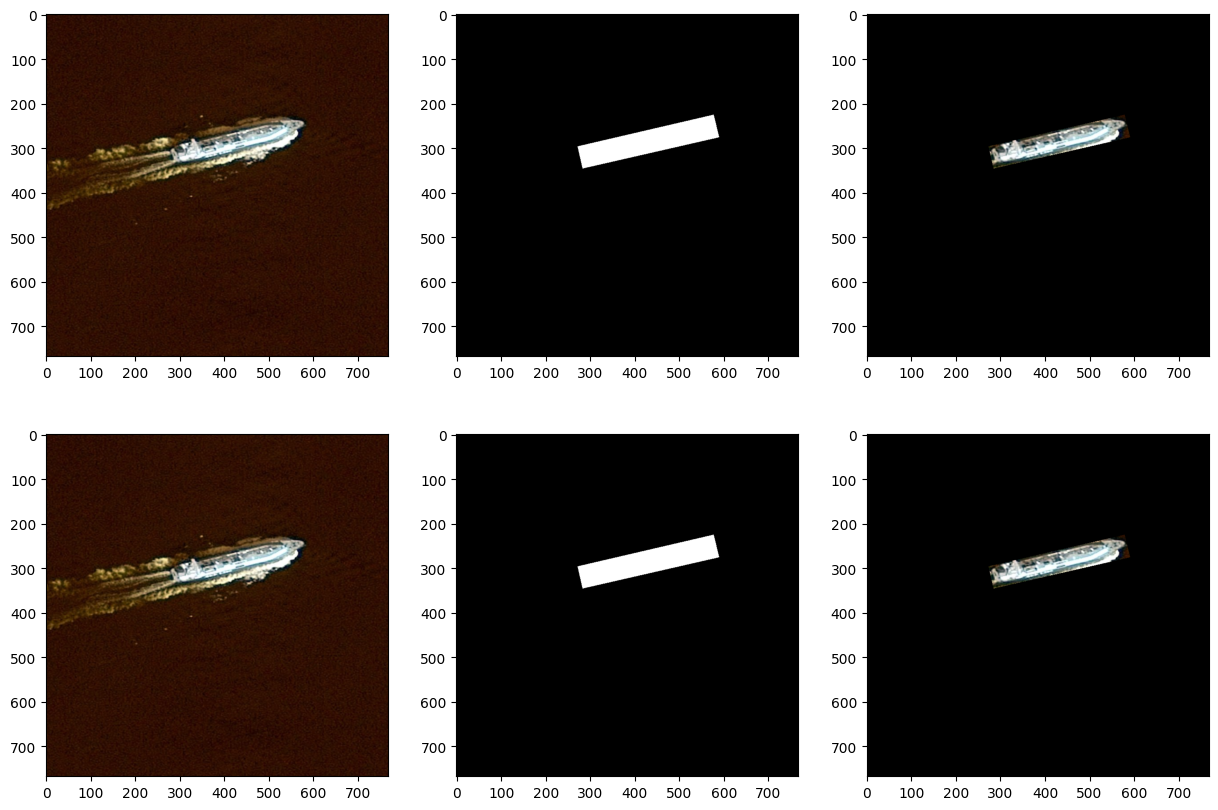

ImageId                                      EncodedPixels  \
32515  241780021.jpg  209962 3 210730 7 211498 12 212265 17 213033 2...   

       ImageHeight  ImageWidth  ShipAreaPercentage  
32515          768         768            2.761671

In [43]:
image_id = '241780021.jpg'
show_image_with_encoded_pixels(image_id)
df[df['ImageId'] == image_id]

We can notice that all the ship segment labels in the training dataset are bounding boxes (rectangles).
At the same time, the ships in the images have a slightly different shape.